In [38]:
import copy
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.special import logsumexp
from shapely.geometry import shape
from scipy.optimize import minimize

# Import data

In [8]:
# Select dataset
dataset = "retail"

In [9]:
# Import relevant data
origin_supply = np.loadtxt(f'../data/input/{dataset}/origin_supply.txt')
initial_destination_sizes = np.loadtxt(f'../data/input/{dataset}/origin_supply.txt')
cost_matrix = np.loadtxt(f'../data/input/{dataset}/cost_matrix.txt')

N,M = cost_matrix.shape

# Compute flows and use them to assert model results

In [10]:
# Set parameters
alpha = 0.02
beta = 1.34
_delta = 0.3
gamma = 1#1e4
epsilon = 1


# Define theta
delta = _delta/M
kappa = 1 + _delta
theta = [alpha,beta,delta,gamma,kappa,epsilon]

# Define log sizes
xd = np.log(initial_destination_sizes/np.sum(initial_destination_sizes))
# Define normalised cost_matrix
cost_matrix_normalised = cost_matrix/np.sum(cost_matrix)
# Define normalised origin_supply
origin_supply_normalised = origin_supply/np.sum(origin_supply)

In [27]:
# As defined in C function
def _logsumexp(xx):
    _max = xx[0]
    for j in range(M):
        if xx[j] > _max:
            _max = xx[j]

    _sum = 0;
    for j in range(M):
        _sum += np.exp(xx[j] - _max);

    return _max + np.log(_sum)

In [30]:
def pot_value(x,params):
    pot = 1
    a = params[0]
    b = params[1]
    d = params[2]
    g = params[3]
    k = params[4]
    e = params[5]
    a_inv = 1./a
    
    grad = np.zeros(M)
    wksp = np.zeros(M)
    
    utility = 0
    for i in range(N):
        for j in range(M):
            wksp[j] = a*x[j] - b*cost_matrix_normalised[i,j]
        temp = _logsumexp(wksp)

        utility += -e*a_inv*origin_supply_normalised[i]*temp;
        
        for j in range(M):
            grad[j] += -e*origin_supply_normalised[i]*np.exp(wksp[j]-temp)
            
    for j in range(M):
        grad[j] += k*np.exp(x[j]) - d
        grad[j] *= g

        
    # Compute cost and additional utilities
    cost = k * np.sum(np.exp(x))
    additional = -d * np.sum(x)

    potential = g*e*(utility+cost+additional)
        
    return potential,grad

In [31]:
# Set grid size
grid_n = 2
amin,amax = (0,2)
bmin,bmax = (0,1.4e6)
potentials = np.zeros((grid_n,grid_n))

# Loop and find potential function value for given alphas and betas
alpha_values = np.linspace(amin, amax, grid_n+1)[1:]
beta_values = np.linspace(bmin, bmax, grid_n+1)[1:]

for i in tqdm(range(grid_n)):
    for j in range(grid_n):
        theta[0] = alpha_values[i]
        theta[1] = beta_values[j]
        potential,gradient = pot_value(xd,theta)
        
        print('alpha =',theta[0],'beta =',theta[1],'delta =',theta[2],'gamma =',theta[3],'kappa =',theta[4],'epsilon =',theta[5])
        print('gradient',gradient)
        w_pred = np.exp(minimize(pot_value, xd, method='L-BFGS-B', jac=True, args=(theta), options={'disp': False}).x)
        potentials[i,j] = potential

  0%|          | 0/2 [00:00<?, ?it/s]

alpha = 1.0 beta = 700000.0 delta = 0.006122448979591836 gamma = 1 kappa = 1.3 epsilon = 1
gradient [-0.04187757 -0.018064   -0.02065708 -0.0354578  -0.01825572 -0.01474878
 -0.04075882 -0.02912634 -0.03628925 -0.01945857 -0.02373785 -0.02511214
 -0.02170729 -0.02047367 -0.0143006  -0.02842481 -0.02395669 -0.01967427
 -0.04359305 -0.01833123 -0.03933676 -0.01984871 -0.0263105  -0.01836294
 -0.02104194 -0.03157874 -0.01920425 -0.02375046 -0.02240443 -0.03178481
 -0.03253261 -0.02826137 -0.02771056 -0.03008141 -0.02199911 -0.02247814
 -0.02072452 -0.0220571  -0.01906589 -0.0195424  -0.02559621 -0.02309683
 -0.02437345 -0.02758678 -0.01814483 -0.01358945 -0.02314677 -0.01788586
 -0.02034267]


ValueError: 0-th dimension must be fixed to 625 but got 49


# Visualise $R^2$

## Commuter borough

In [36]:
r2_values = np.loadtxt('../data/output/commuter_borough/inverse_problem/singly_rsquared_analysis_100.txt')
with open('../data/output/commuter_borough/inverse_problem/figures/singly_rsquared_analysis_gamma_100_parameters.json') as json_file:
    metadata = json.load(json_file)
grid_n = metadata['grid_size']
amin = metadata['amin']
amax = metadata['amax']
bmin = metadata['bmin']
bmax = metadata['bmax']
alpha_values = np.linspace(amin, amax, grid_n+1)[1:]
beta_values = np.linspace(bmin, bmax, grid_n+1)[1:]
XX, YY = np.meshgrid(alpha_values, beta_values)

idx = np.unravel_index(r2_values.argmax(), r2_values.shape)
print("Fitted alpha and beta values:")
print(XX[idx], YY[idx]*amax/bmax, r2_values[idx])

Fitted alpha and beta values:
1.08 0.08 0.5052418847038942


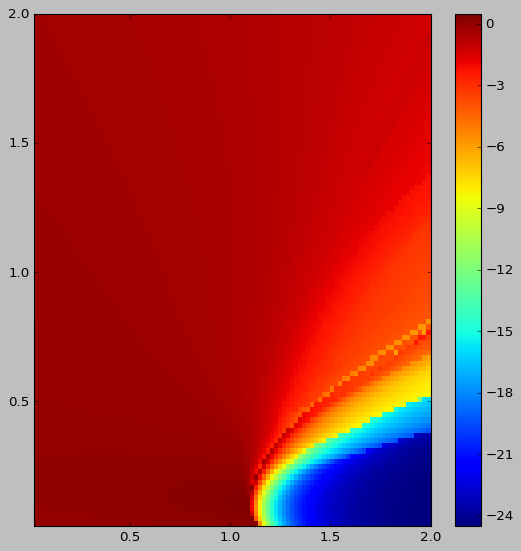

In [37]:
plt.style.use('classic')
fig = plt.figure(figsize=(8,8))
fig.tight_layout(pad=0.5)
plt.pcolor(XX, YY*amax/bmax, r2_values)
plt.xlim([np.min(XX), np.max(XX)])
plt.ylim([np.min(YY)*amax/bmax, np.max(YY)*amax/bmax])
plt.colorbar()
plt.savefig('../data/output/commuter_borough/inverse_problem/figures/singly_rsquared_analysis_gamma_100.png')